#Another Laplacian with exact solution (source term)

## import basic modules

In [1]:
from getfem import Mesh, MeshFem, Fem, MeshIm, Integ, Model, compute
from numpy import arange, compress

## boundary names

In [2]:
top   = 101 # Dirichlet boundary
down  = 102 # Neumann boundary
left  = 103 # Dirichlet boundary
right = 104 # Neumann boundary

## parameters

In [3]:
NX = 40                             # Mesh parameter
Dirichlet_with_multipliers = True;  # Dirichlet condition with multipliers or penalization
dirichlet_coefficient = 1e10;       # Penalization coefficient

## mesh creation

In [4]:
m = Mesh('regular_simplices', arange(0,1+1./NX,1./NX), arange(0,1+1./NX,1./NX))

## create a MeshFem for u and rhs fields of dimension 1 (i.e. a scalar field)

In [5]:
mfu   = MeshFem(m, 1)
mfrhs = MeshFem(m, 1)

## assign the P2 fem to all convexes of the both MeshFem

In [6]:
mfu.set_fem(Fem('FEM_PK(2,2)'))
mfrhs.set_fem(Fem('FEM_PK(2,2)'))

## an exact integration will be used

In [7]:
mim = MeshIm(m, Integ('IM_TRIANGLE(4)'))

## boundary selection

In [8]:
flst   = m.outer_faces()
fnor   = m.normal_of_faces(flst)
ttop   = abs(fnor[1,:]-1) < 1e-14
tdown  = abs(fnor[1,:]+1) < 1e-14
tleft  = abs(fnor[0,:]+1) < 1e-14
tright = abs(fnor[0,:]-1) < 1e-14
ftop   = compress(ttop, flst, axis=1)
fdown  = compress(tdown, flst, axis=1)
fleft  = compress(tleft, flst, axis=1)
fright = compress(tright, flst, axis=1)

## mark it as boundary

In [9]:
m.set_region(top, ftop)
m.set_region(down, fdown)
m.set_region(left, fleft)
m.set_region(right, fright)

## interpolate the exact solution (assuming mfu is a Lagrange fem)

In [10]:
g = mfu.eval('y*(y-1)*x*(x-1)+x*x*x*x*x')

## interpolate the source terms (assuming mfrhs is a Lagrange fem)

In [11]:
f = mfrhs.eval('-(2*(x*x+y*y)-2*x-2*y+20*x*x*x)')
h = mfrhs.eval('[y*(y-1)*(2*x-1) + 5*x*x*x*x, x*(x-1)*(2*y-1)]')

## model

In [12]:
md = Model('real')

## add variable and data to model

In [13]:
md.add_fem_variable('u', mfu)              # main unknown
md.add_initialized_fem_data('f', mfrhs, f) # volumic source term
md.add_initialized_fem_data('g', mfrhs, g) # Dirichlet condition
md.add_initialized_fem_data('h', mfrhs, h) # Neumann condition

## bricked the problem

In [14]:
md.add_Laplacian_brick(mim, 'u')                             # laplacian term on u
md.add_source_term_brick(mim, 'u', 'f')                      # volumic source term
md.add_normal_source_term_brick(mim, 'u', 'h', down)         # Neumann condition
md.add_normal_source_term_brick(mim, 'u', 'h', left)         # Neumann condition

3

## Dirichlet condition on the top

In [15]:
if (Dirichlet_with_multipliers):
  md.add_Dirichlet_condition_with_multipliers(mim, 'u', mfu, top, 'g')
else:
  md.add_Dirichlet_condition_with_penalization(mim, 'u', dirichlet_coefficient, top, 'g')

## Dirichlet condition on the right

In [16]:
if (Dirichlet_with_multipliers):
  md.add_Dirichlet_condition_with_multipliers(mim, 'u', mfu, right, 'g')
else:
  md.add_Dirichlet_condition_with_penalization(mim, 'u', dirichlet_coefficient, right, 'g')

## assembly of the linear system and solve.

In [17]:
md.solve()

(0, 1)

## main unknown

In [18]:
u  = md.variable('u')
L2error = compute(mfu, u-g, 'L2 norm', mim)
H1error = compute(mfu, u-g, 'H1 norm', mim)

In [19]:
#if (H1error > 1e-3):
print 'Error in L2 norm : ', L2error
print 'Error in H1 norm : ', H1error
#print 'Error too large !'

Error in L2 norm :  1.135122042e-06
Error in H1 norm :  0.000248087898054


## export data

In [20]:
mfu.export_to_pos('sol.pos', g,'Exact solution',
                             u,'Computed solution')

In [21]:
%%writefile gscript
Print "Another_Laplacian_with_exact_solution_and_source_term_python_image1.png";
Exit;

Overwriting gscript


In [22]:
!gmsh sol.pos gscript

In [23]:
from IPython.core.display import Image

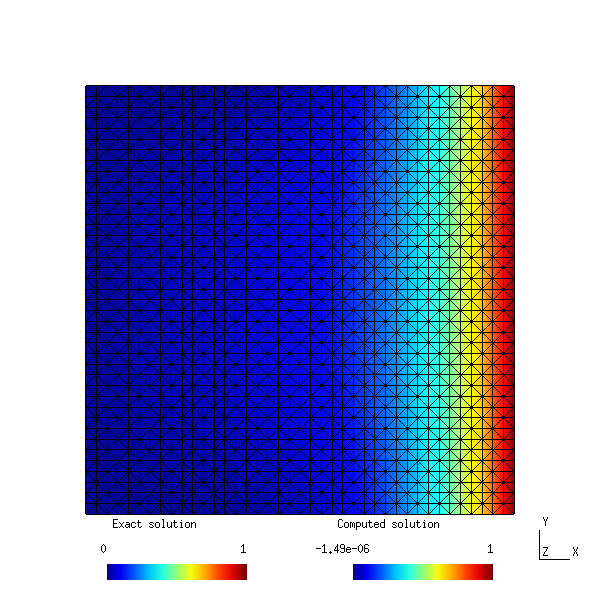

In [24]:
Image('Another_Laplacian_with_exact_solution_and_source_term_python_image1.png')